In [37]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
clean_df = pd.read_sql_query('select * from "merged_final"',con=engine)

In [ ]:
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [106]:
clean_merged = clean_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
clean_merged.drop(['index_x', 'index_y'], axis=1, inplace=True)

## Feature Engineering

In [ ]:
clean_merged['bill_length'] = clean_merged['bill_text'].apply(lambda x: len(x))

In [135]:
sample = clean_merged.sample(n=200000)

In [136]:
sample = sample[sample['vote'] <= 1]

In [137]:
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,district,party,is_primary_sponsor,is_minority_party,is_secondary_sponsor,sponsor_party,bill_text,bill_length
1408128,1,2002-02-15,347,1,2001-02 ESSB 6499,44615.0,2001-02,ESSB 6499,http://app.leg.wa.gov/documents/billdocs/2001-...,1,2,0,False,False,False,0,\n\n\n\n\n\n\n\n______________________________...,80489
619785,1,1996-03-01,180,1,1995-96 EHB 2672,17850.0,1995-96,EHB 2672,http://app.leg.wa.gov/documents/billdocs/1995-...,0,34,0,False,False,False,1,\n\n\n\n2672.PL [atlas:SL]\n\n\n\n\n\nCERTIFIC...,4959
673077,1,1995-04-06,173,0,1995-96 E2SSB 5439,19565.0,1995-96,E2SSB 5439,http://app.leg.wa.gov/documents/billdocs/1995-...,1,19,0,False,True,False,0,\n\n\n\n5439-S2.SL\n\n\n\n\nCERTIFICATION\nOF ...,198594
786072,1,1997-04-10,309,1,1997-98 HB 1367,23103.0,1997-98,HB 1367,http://app.leg.wa.gov/documents/billdocs/1997-...,0,15,1,False,False,False,1,\n\n\n\n\n\n\n\n\nCERTIFICATION\nOF ENROLLMENT...,5524
641299,0,1996-03-06,1591,0,1995-96 EHCR 4427,18459.0,1995-96,EHCR 4427,http://app.leg.wa.gov/documents/billdocs/1995-...,0,18,1,False,False,False,1,\n\n\n\n4427.E [atlas:bill]\n\n\n\n\n_________...,1028


In [138]:
len(sample['vote'])

200000

In [139]:
sample['vote'].sum()

180136

### Thing to consider
bill length  
NLP  
google search data
year
topics

In [91]:
1751152/1942788

0.9013603131170256

### Baseline Model

In [55]:
X = sample[['sponsor_party', 'party']]
y = sample['vote']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=709)

In [57]:
baseline_model = LogisticRegression()

In [58]:
baseline_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
y_pred = baseline_model.predict_proba(X_test)

In [60]:
log_loss(y_test, y_pred)

0.31977793510725233

### Second Model

In [74]:
X_2 = sample[['sponsor_party', 'party', 'voting_agency', 'sponsor_agency', 
              'district', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 'voter_id']]
y_2 = sample['vote']

In [75]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.30, random_state=709)

In [76]:
second_model = LogisticRegression()

In [77]:
second_model.fit(X_train_2, y_train_2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
y_pred_2 = second_model.predict_proba(X_test_2)

In [79]:
log_loss(y_test_2, y_pred_2)

0.3146348136734083

In [80]:
len(y_test_2), len(y_pred_2)

(583137, 583137)

In [81]:
y_test_2.shape, y_pred_2.shape

((583137,), (583137, 2))

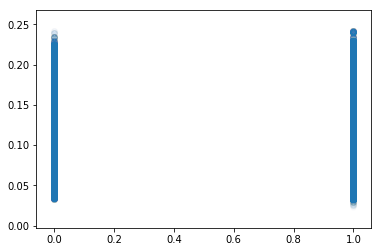

In [82]:
fig, ax = plt.subplots()
ax.scatter(y_test_2, y_pred_2[:,0], alpha=0.01)

In [83]:
len(y_pred_2)

583137

In [84]:
sum(y_pred_2)

array([ 59292.49536593, 523844.50463414])

### Third Model

In [85]:
r_model = RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=2, random_state=709)

In [86]:
r_model.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=709, verbose=0, warm_start=False)

In [99]:
y_pred_r = r_model.predict_proba(X_test_2)

In [100]:
log_loss(y_test_2, y_pred_r)

0.3060378183692334

In [104]:
y_pred_r[:, 1].min()

0.6776477007265272

## With bill_length

In [174]:
X_3 = sample[['sponsor_party', 'party', 'voting_agency', 'sponsor_agency', 'district', 
                    'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                    'voter_id', 'bill_length', 'unique_id']]
y_3 = sample['vote']

In [175]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.30, random_state=709)

In [176]:
r_model_3 = RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=2, random_state=709)

In [177]:
r_model_3.fit(X_train_3, y_train_3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=2,
            oob_score=False, random_state=709, verbose=0, warm_start=False)

In [178]:
y_pred_r_3 = r_model_3.predict_proba(X_test_3)

In [179]:
log_loss(y_test_3, y_pred_r_3)

0.2970177452529127

In [180]:
y_pred_r_3[:, 1].min()

0.2601933595685523

In [181]:
controversy score
run nate silver simulations

SyntaxError: invalid syntax (<ipython-input-181-db5a741335c0>, line 1)

## Explore bill_text

In [168]:
sample

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,district,party,is_primary_sponsor,is_minority_party,is_secondary_sponsor,sponsor_party,bill_text,bill_length
1408128,1,2002-02-15,347,1,2001-02 ESSB 6499,44615.0,2001-02,ESSB 6499,http://app.leg.wa.gov/documents/billdocs/2001-...,1,2,0,False,False,False,0,\n\n\n\n\n\n\n\n______________________________...,80489
619785,1,1996-03-01,180,1,1995-96 EHB 2672,17850.0,1995-96,EHB 2672,http://app.leg.wa.gov/documents/billdocs/1995-...,0,34,0,False,False,False,1,\n\n\n\n2672.PL [atlas:SL]\n\n\n\n\n\nCERTIFIC...,4959
673077,1,1995-04-06,173,0,1995-96 E2SSB 5439,19565.0,1995-96,E2SSB 5439,http://app.leg.wa.gov/documents/billdocs/1995-...,1,19,0,False,True,False,0,\n\n\n\n5439-S2.SL\n\n\n\n\nCERTIFICATION\nOF ...,198594
786072,1,1997-04-10,309,1,1997-98 HB 1367,23103.0,1997-98,HB 1367,http://app.leg.wa.gov/documents/billdocs/1997-...,0,15,1,False,False,False,1,\n\n\n\n\n\n\n\n\nCERTIFICATION\nOF ENROLLMENT...,5524
641299,0,1996-03-06,1591,0,1995-96 EHCR 4427,18459.0,1995-96,EHCR 4427,http://app.leg.wa.gov/documents/billdocs/1995-...,0,18,1,False,False,False,1,\n\n\n\n4427.E [atlas:bill]\n\n\n\n\n_________...,1028
1652596,0,2005-02-18,1609,0,2005-06 SHB 1219,53899.0,2005-06,SHB 1219,http://app.leg.wa.gov/documents/billdocs/2005-...,0,14,1,False,True,False,0,\n\nBILL REQ. #: H-1354.1 ___________________...,7009
1507055,1,2004-02-13,8212,0,2003-04 EHB 2654,48654.0,2003-04,EHB 2654,http://app.leg.wa.gov/documents/billdocs/2003-...,0,49,0,False,False,False,0,\n\n__________________________________________...,15706
447473,1,1992-02-14,304,0,1991-92 SHB 2750,3388.0,1991-92,SHB 2750,http://app.leg.wa.gov/documents/billdocs/1991-...,0,9,1,False,True,False,0,\n\n\n\nH-4703\n\n\n\n\nH-4703.1 ____...,2406
478335,1,1991-03-08,269,1,1991-92 SSB 5180,4530.0,1991-92,SSB 5180,http://app.leg.wa.gov/documents/billdocs/1991-...,1,48,1,False,False,False,1,\n\n\n\nS-1552\n\n\n\n\n\n\n\n\n\nS-1552.1 ...,1873
2242010,1,2009-03-30,630,0,2009-10 E2SHB 2029,72757.0,2009-10,E2SHB 2029,http://app.leg.wa.gov/documents/billdocs/2009-...,0,39,0,False,False,True,0,\n\nBILL REQ. #: H-2638.1 ___________________...,63576


In [167]:
print(sample.loc[1408128, 'bill_text'])









_______________________________________________

ENGROSSED SUBSTITUTE SENATE BILL 6499
_______________________________________________

State of Washington   57th Legislature        2002
Regular Session

By Senate Committee on Human
Services & Corrections (originally sponsored by Senators Kline, Hargrove,
Costa, Long, Regala, Winsley and Kohl‑Welles; by request of Department of
Corrections)

READ FIRST TIME 02/08/2002.
Changing provisions
relating to supervision of offenders.




AN ACT Relating to
supervision of offenders; amending RCW 9.94A.545, 9.94A.631, 9.94A.637,
9.94A.650, 9.94A.690, 9.94A.700, 9.94A.705, 9.94A.715, 9.94A.720, 9.94A.740,
9.94A.750, 9.94A.760, 9.92.060, 9.95.204, 9.95.210, 72.04A.090, 4.56.100,
72.65.080, and 41.06.380; reenacting and amending RCW 9.94A.753; and providing
an effective date.

BE IT ENACTED BY THE LEGISLATURE OF THE STATE OF
WASHINGTON:

Sec. 1.  RCW 9.94A.545 and 2000 c
28 s 13 are each amended to read as follows:
(1) On all
sentences of c